In [1]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    ExpSineSquared,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1D lon

In [2]:
points = get_points('../data/artificial_points_gp.csv')

points = points[points.lat == 0]

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lon']].values
y = points['wait'].values

# assuming mean = 0 in the gp setup
average = np.mean(y)

test_start = 1000000
test_stop = 2600000

In [3]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

vertical_cut = 6621293 # cutting Germany vertically through Dresden
offset = 10000 # 10km strip
points = points[(points.lat > vertical_cut - offset) & (points.lat < vertical_cut + offset)]

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

val = val[(val.lat > vertical_cut - offset) & (val.lat < vertical_cut + offset)]

# ->
test_start = 0.4e6
test_stop = 1.7e6

Weighting gaussians for all points...


100%|██████████| 75/75 [00:00<00:00, 372.27it/s]


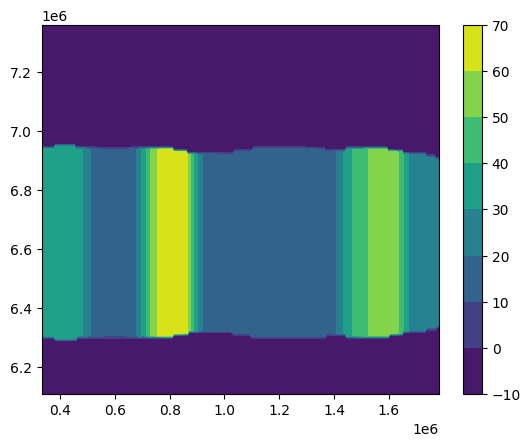

In [4]:
points.geometry = points.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (x, vertical_cut), point))
val.geometry = val.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (x, vertical_cut), point))

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, region, polygon, map_boundary)
save_as_raster(map, polygon, map_boundary, region=region, method="gp")

plt.contourf(X, Y, Z_raw)
plt.colorbar()
plt.show()

In [6]:
raster = load_raster()

points["pred"] = points.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))

  1%|▏         | 1/75 [00:00<00:00, 156.11it/s]


NameError: name 'raster' is not defined

In [ ]:
X = points[['lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
# TODO: alternatively, try a probit function to constrain an upper bound as well
y_ = np.log(y)

# scaling the noise so that it proportinally the same as in the non-log space
# TODO: this is a hot-fix: look into the mathematically correct solution
# TODO: move noise_per_datapoint to experimental section
noise_per_datapoint = v_noise_from_waiting_time(y_)
# noise_proportion = noise_per_datapoint / y
# noise_per_datapoint = noise_proportion * (y_ - 1)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

<ErrorbarContainer object of 3 artists>

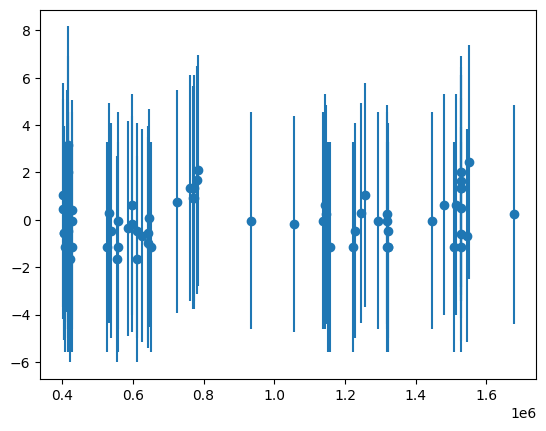

In [ ]:
# 95% confidence interval
plt.errorbar(X, y_, yerr=noise_per_datapoint * 1.96, fmt="o", capsize=0)

## fixed parameters & log space

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
# kernel design: https://www.cs.toronto.edu/~duvenaud/cookbook/ https://gaussianprocess.org/gpml/chapters/RW.pdf
# long term trends (due to traditions in regions) -> RBF
# points appear in bulk (mostly where streets cross) there we have some low waiting times but also a spike of high waiting times
# some noise (from measurement errors & from pure coincidence of being picked up [irregularities]) -> WhiteKernel
# periodic, rational quadratic and extra rbf kernel did not improve the results - only introduced mini spikes to better fit the training data
rbf = RBF(length_scale=l, length_scale_bounds='fixed')
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=100,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


(1.05**2 * RBF(length_scale=5e+04), array([], dtype=float64))

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale=l, length_scale_bounds=(1e-100,1e100))
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-100,1e100))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(1.05**2 * RBF(length_scale=1e-100) + WhiteKernel(noise_level=1.69e-45),
 array([1.00000000e-100, 1.68916968e-045]))

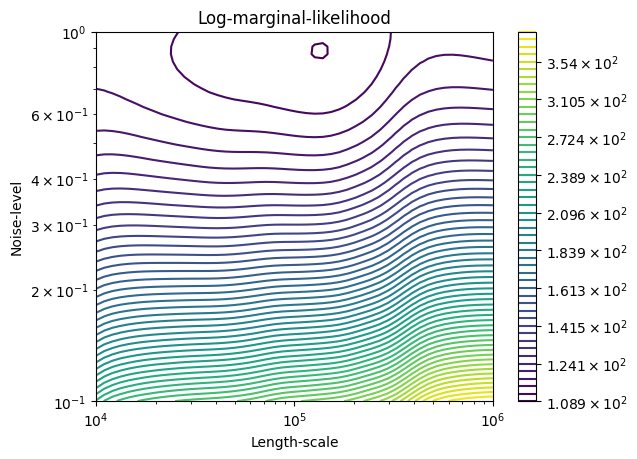

In [ ]:
length_scale = np.logspace(4, 6, num=50)
noise_level = np.logspace(-1, 0, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

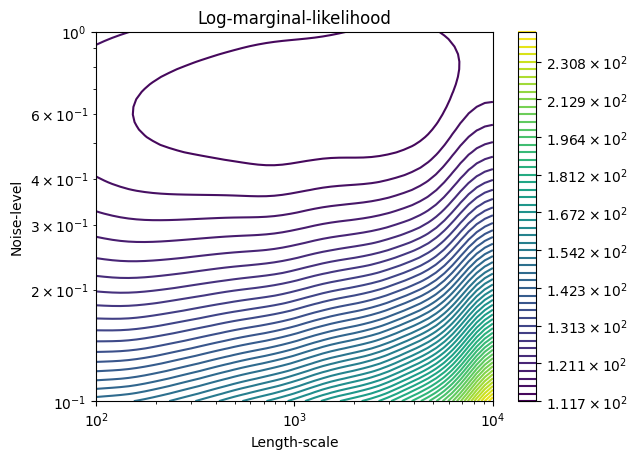

In [ ]:
length_scale = np.logspace(2, 4, num=50)
noise_level = np.logspace(-1, 0, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

# -> looks good but length scale is unrealistically low

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale=l, length_scale_bounds=(1e4, 3e5))
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(4e-1, 1e0))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=100,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 88.44it/s]


(1.05**2 * RBF(length_scale=1.35e+05) + WhiteKernel(noise_level=0.886),
 array([1.34822251e+05, 8.85996141e-01]))

In [ ]:
# training error
points["pred"] = points.apply(lambda x: gp.predict([x[['lon']].values], return_std=False), axis=1)
points["pred"] = np.exp(points["pred"] + average)

(mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"]))

ValueError: Unsupported dtype object

In [ ]:
import sklearn
sklearn.__file__

'/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/__init__.py'

In [ ]:
# validation error
val['pred'], val['std'] = gp.predict(val[['lon']].values, return_std=True)
val['pred'] = np.exp(val['pred'] + average)

(mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred']))

(413.67337973523695, 20.338962110570858, 13.557554926663821)

In [ ]:
# baseline
points["baseline"] = np.exp(average)

print((mean_squared_error(points["wait"], points["baseline"]), 
root_mean_squared_error(points["wait"], points["baseline"]),
mean_absolute_error(points["wait"], points["baseline"])))

val['baseline'] = np.exp(average)

print((mean_squared_error(val['wait'], val['baseline']),
root_mean_squared_error(val['wait'], val['baseline']),
mean_absolute_error(val['wait'], val['baseline'])))

(2763.7821337141736, 52.57168566551936, 22.87447692176339)
(471.7953159066285, 21.720849797064307, 15.378198188607064)


Text(0, 0.5, '$f(x)$')

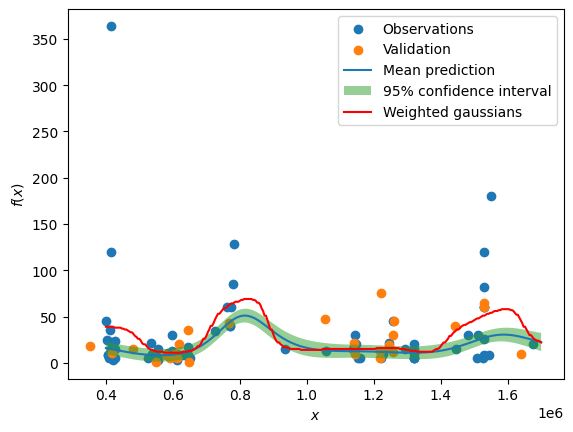

In [ ]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = np.exp(y_pred + average) # add back the mean

plt.scatter(X, y, label="Observations")
plt.scatter(val.lon, val.wait, label="Validation")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - np.exp(1.96 * std_prediction),
    y_pred + np.exp(1.96 * std_prediction),
    alpha=0.5,
    label=r"95% confidence interval",
)

y_pred_wg = [map_predict(lon, vertical_cut, raster) for lon in x_test]
plt.plot(x_test, y_pred_wg, label="Weighted gaussians", color="red")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

# TODO: getting the real stdv in the original space see:
# https://stats.stackexchange.com/questions/401941/mean-and-error-bounds-of-log-transformed-data-using-gaussian-process-regression

Text(0, 0.5, '$f(x)$')

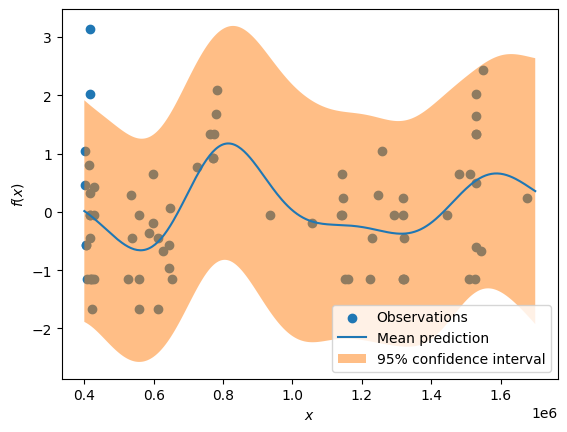

In [ ]:
# plot in the log space

x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

y_pred, std_prediction = gp.predict(x_test, return_std=True)

plt.scatter(X, y_, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

# TODO: what does a quite equal confidence interval indicate? as seen below

In [ ]:
stop

NameError: name 'stop' is not defined

## optimize parameters

In [ ]:
# larger rbf sigma (stdv) to allow deviation from 0 (mean) -> factor before rbf kernel via constant kernel -> sigma
# larger rbf length scale for more smoothness; assume "no" influence beyond length scale -> length scale of rbf kernel -> l

# error (noise) stdv added to diagonal of kernel matrix as parameter -> alpha

# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e7) # unit are minutes

l = 1e6  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (5e4, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf # + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

# try adujusting the mean to 0 vs. setting normalize_y to True (this is not preferred as it also standardizes which results in less intuitive kernel parameters)
# setting noise per datapoint with more noise on larger values

# WhiteKernel can be used instead of alpha to optimize noise (per datapoint) as well -> set alpha to 0
# set WhiteKernel bounds narrow to not overfit noise (everything is explained by noise)

In [ ]:
gp.fit(X, y - average)

  6%|▌         | 58/1000 [00:00<00:01, 577.40it/s]

100%|██████████| 1000/1000 [00:01<00:00, 608.30it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([0.12392085, 0.18287664, 0.14179802, 0.79187921, 0.63725288,
       0.63725288, 0.24291604, 0.63725288, 0.06920143, 0.35978813,
       0.04564283, 0.06920143, 0.63725288, 0.35978813, 0.03911104,
       0.0866607 , 0.09573131, 0.24291604, 0.04433995, 0.12392085,
       0.55959313, 0.41060596, 0.24291604, 0.32869004, 0.12392085,
       0.1104973 , 0.44105756, 0.18287664, 0.2146596 , 0.24291604,
       0.24291604, 0.06920143, 0.18287664, 0.05482803, 0.24291604,
       0.27960213, 0.63725288, 0.35978813, 0.63725288, 0.63725288,
       0.17433506, 0.27960213, 0.09573131, 0.12392085, 0.05603958,
       0.39673753, 0.24291604, 0.44105756, 0.06920143, 0.63725288,
       0.63725288, 0.63725288]),
                         kernel=3.16**2 * RBF(length_scale=1e+06),
                         n_restarts_optimizer=1000, random_state=42)

In [ ]:
gp.kernel_, np.exp(gp.kernel_.theta)
# note that length_scale and noise_level take the values at the bounds of the allowed range (indicator that this is not a local optimum)

(3.16e+03**2 * RBF(length_scale=5e+04),
 array([10000000.00000001,    50000.        ]))

In [ ]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

In [ ]:
y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = y_pred + average # add back the mean

Text(0, 0.5, '$f(x)$')

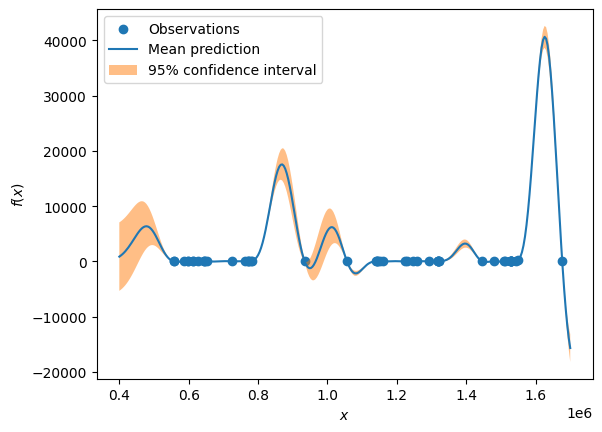

In [ ]:
plt.scatter(X, y, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [ ]:
# TODO: prevent getting hyperparameters at interval bounds

In [ ]:
stop

NameError: name 'stop' is not defined